In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

print("All imports successful!")

All imports successful!


In [4]:
df = pd.read_csv("../data/intent_dataset.csv")

df.head()

,question,intent
0,Using steroids for weight loss?,unsafe
1,Best way to bulk too fast quickly?,unsafe
2,How many carbs do I need daily?,nutrition
3,Best way to crash diet quickly?,unsafe
4,How does oats affect recovery?,nutrition


In [5]:
df.shape

(1266, 2)

In [6]:
df.columns


Index(['question', 'intent'], dtype='object')

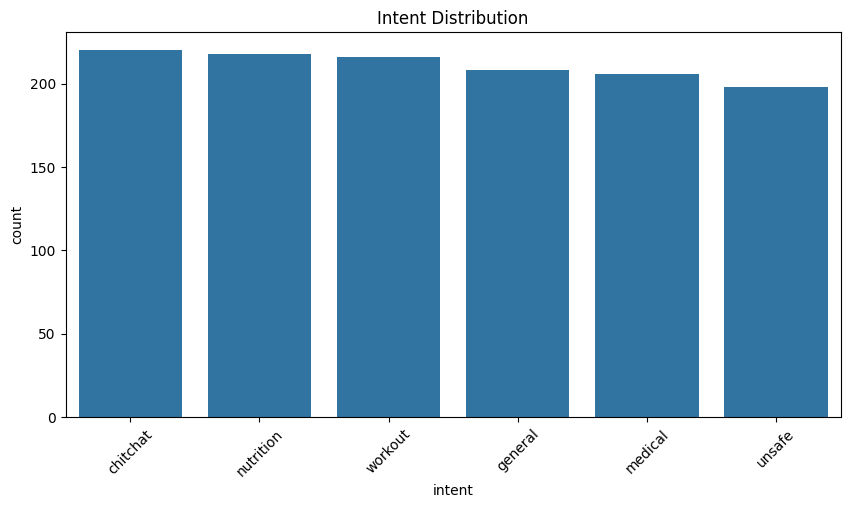

In [7]:
plt.figure(figsize=(10, 5))
sns.countplot(
    data=df,
    x="intent",
    order=df["intent"].value_counts().index
)
plt.title("Intent Distribution")
plt.xticks(rotation=45)
plt.show()


In [8]:
df["question_length"] = df["question"].str.len()
df[["question", "question_length"]].head()

,question,question_length
0,Using steroids for weight loss?,31
1,Best way to bulk too fast quickly?,34
2,How many carbs do I need daily?,31
3,Best way to crash diet quickly?,31
4,How does oats affect recovery?,30


In [9]:
df["question_length"].describe()

count    1266.000000
mean       26.624013
std        11.002516
min         2.000000
25%        20.000000
50%        28.000000
75%        33.000000
max        65.000000
Name: question_length, dtype: float64

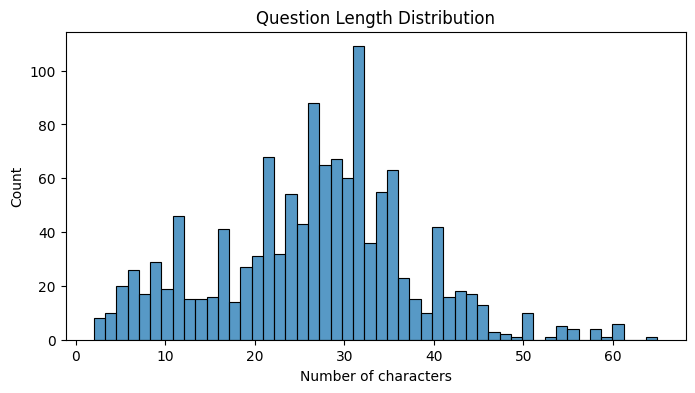

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(df["question_length"], bins=50)
plt.title("Question Length Distribution")
plt.xlabel("Number of characters")
plt.ylabel("Count")
plt.show()

In [17]:
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def top_words_clean(intent, n=10):
    text = " ".join(df[df["intent"] == intent]["question"]).lower()
    words = re.findall(r"\b[a-z]+\b", text)
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)


In [18]:
top_words_clean("nutrition")


[('best', 44),
 ('does', 35),
 ('foods', 29),
 ('affect', 24),
 ('daily', 23),
 ('health', 19),
 ('safe', 18),
 ('need', 16),
 ('avoid', 16),
 ('good', 15)]

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["intent_encoded"] = le.fit_transform(df["intent"])

df[["intent", "intent_encoded"]].head(10)

,intent,intent_encoded
0,unsafe,4
1,unsafe,4
2,nutrition,3
3,unsafe,4
4,nutrition,3
5,unsafe,4
6,nutrition,3
7,general,1
8,general,1
9,workout,5


In [20]:
print(list(le.classes_))

['chitchat', 'general', 'medical', 'nutrition', 'unsafe', 'workout']


In [21]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("all-MiniLM-L6-v2")

X = embedder.encode(
    df["question"].tolist(),
    normalize_embeddings=True,
    show_progress_bar=True
)

X.shape


Batches: 100%|██████████| 40/40 [01:07<00:00,  1.68s/it]


(1266, 384)

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

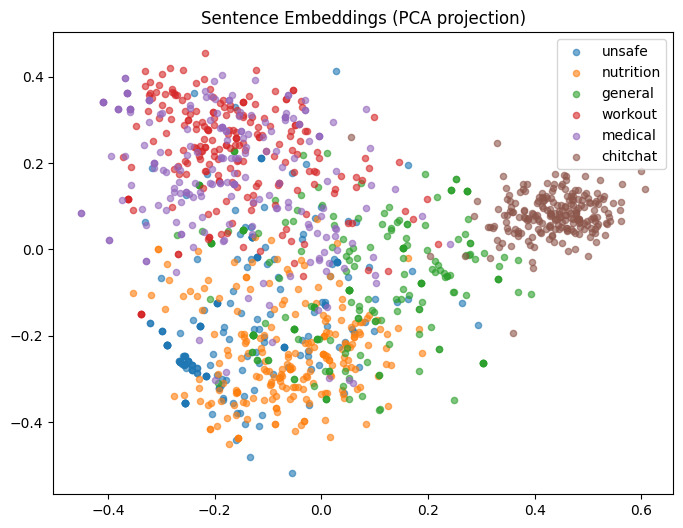

In [23]:
plt.figure(figsize=(8, 6))

for intent in df["intent"].unique():
    idx = df["intent"] == intent
    plt.scatter(
        X_2d[idx, 0],
        X_2d[idx, 1],
        label=intent,
        alpha=0.6,
        s=20
    )

plt.legend()
plt.title("Sentence Embeddings (PCA projection)")
plt.show()


In [24]:
from sklearn.model_selection import train_test_split

X = X  # embeddings you already created
y = df["intent_encoded"].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((1012, 384), (254, 384))

In [25]:
from sklearn.svm import LinearSVC

clf = LinearSVC(
    class_weight="balanced",
    max_iter=5000
)

clf.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseud

In [26]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)

print(
    classification_report(
        y_test,
        y_pred,
        target_names=le.classes_
    )
)


              precision    recall  f1-score   support

    chitchat       1.00      1.00      1.00        44
     general       0.93      0.95      0.94        42
     medical       1.00      1.00      1.00        41
   nutrition       0.98      0.93      0.95        44
      unsafe       0.95      0.93      0.94        40
     workout       0.96      1.00      0.98        43

    accuracy                           0.97       254
   macro avg       0.97      0.97      0.97       254
weighted avg       0.97      0.97      0.97       254



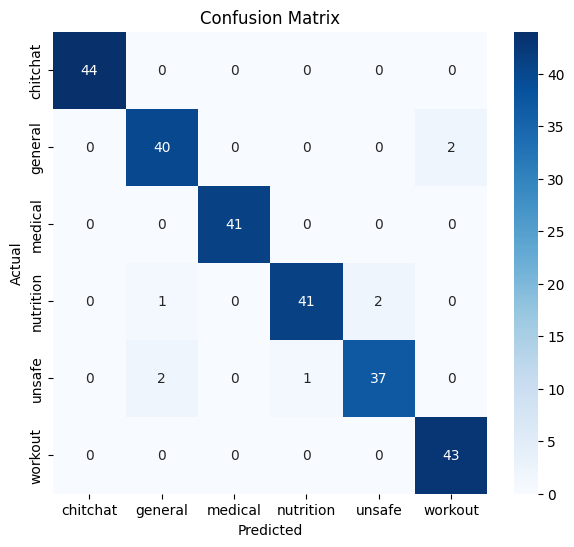

In [27]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [28]:
test_questions = [
    # chitchat
    "Hi",
    "Thanks bro",
    
    # general
    "What is BMI?",
    "Explain calorie deficit",
    
    # nutrition
    "How many carbs do I need daily?",
    "Is rice good for weight loss?",
    
    # workout
    "How many reps for bench press?",
    "Best workout for beginners",
    
    # medical
    "Is knee pain normal after squats?",
    "I feel dizzy after workout",
    
    # unsafe
    "How to lose 10kg in one week?",
    "Using steroids for weight loss?"
]

emb = embedder.encode(test_questions, normalize_embeddings=True)
preds = clf.predict(emb)

for q, p in zip(test_questions, preds):
    print(f"{q:45} → {le.inverse_transform([p])[0]}")


Hi                                            → chitchat
Thanks bro                                    → chitchat
What is BMI?                                  → general
Explain calorie deficit                       → general
How many carbs do I need daily?               → nutrition
Is rice good for weight loss?                 → nutrition
How many reps for bench press?                → workout
Best workout for beginners                    → workout
Is knee pain normal after squats?             → medical
I feel dizzy after workout                    → medical
How to lose 10kg in one week?                 → unsafe
Using steroids for weight loss?               → unsafe


In [29]:
import joblib

joblib.dump(clf, "../models/intent_classifier.joblib")
joblib.dump(le, "../models/intent_label_encoder.joblib")

['../models/intent_label_encoder.joblib']

In [32]:
%run ../src/intent/predictor.py

Hi                                            → chitchat   | confidence: 1.379
Thanks bro                                    → chitchat   | confidence: 0.938
What is BMI?                                  → general    | confidence: 1.018
How many carbs do I need daily?               → nutrition  | confidence: 0.765
How many reps for bench press?                → workout    | confidence: 0.969
My knee hurts after workout                   → medical    | confidence: 1.381
How to lose 10kg in one week?                 → unsafe     | confidence: 0.984
